# The Digit Recognizer - Day 1

Today I start with my first projet, the Digit Recognizer, a challenge from Kaggle for beginners. On Kaggle only csv files are uploaded, but I want to learn how to use the original source material, so I download the .gz files from http://yann.lecun.com/exdb/mnist/

Since the files are stored in binary format, I first need to make them usable for me, to do this I use gzip to read the contents of the .gz files and struct to unzip these files.

In [12]:
import os
import gzip
import numpy as np
import struct
import urllib.request

def download_mnist(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Download complete.")

# Download the dataset
mnist_url = "http://yann.lecun.com/exdb/mnist/"
train_images = "train-images-idx3-ubyte.gz"
train_labels = "train-labels-idx1-ubyte.gz"
test_images = "t10k-images-idx3-ubyte.gz"
test_labels = "t10k-labels-idx1-ubyte.gz"

download_mnist(mnist_url + train_images, train_images)
download_mnist(mnist_url + train_labels, train_labels)
download_mnist(mnist_url + test_images, test_images)
download_mnist(mnist_url + test_labels, test_labels)

# Import the dataset
def load_mnist(images_path, labels_path):
    with gzip.open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

X_train, y_train = load_mnist("train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz")
X_test, y_test = load_mnist("t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz")

Now all that remains is to convert the data into the correct 28x28 pixel form.

In [13]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

My next step is the definition of the model. I know that Convolutional Neural Networks are used for image recognition, so I will do that here too. I start with two convolutional layers and two dense layers and see if I can get it to work. According to the internet it is normal to start with a filter count of 32 in the first conv layer, so I do that here too, followed by a max pooling layer with stride (2,2), which is also standard.
I use he_normal as kernel_initalizer, as it is supposed to work well with "relu".

In [14]:
from tensorflow.keras import layers, models

img_width = 28
img_height = 28
num_channels = 1

# Inputs to the model
input_img = layers.Input(shape=(img_width, img_height, num_channels), 
                         name="image", 
                         dtype="float32"
                         )

# First conv block
x = layers.Conv2D(32,
                  (3, 3),
                  activation="relu",
                  kernel_initializer="he_normal",
                  name="Conv1",
                  )(input_img)

# First Max Pooling Layer
x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

# Second conv block
x = layers.Conv2D(64,
                  (3, 3),
                  activation="relu",
                  kernel_initializer="he_normal",
                  name="Conv2",
                  )(input_img)

# Second Max Pooling Layer
x = layers.MaxPooling2D((2, 2), name="Pool2")(x)

After the Conv part comes a Flatten layer, so that the output can be used as input for the following Dense layer.

In [15]:
# Flatten the input
x = layers.Flatten()(x)

The use of two dense layers in a deep learning model is common in many tasks, including image classification. The first dense layer is used to learn a high-level representation of the input data, while the second dense layer is used to make the final prediction. The 'softmax' activation function is commonly used in the output layer of a deep learning model for classification tasks, as it converts the outputs of the model into a probability distribution over the classes. The 10 in the Dense Layer is because I have 10 digits. The Adam optimizer is a popular choice in deep learning, so I go with that. "sparse_categorical_crossentropy" is a loss function used in multi-class classification problems where each sample has a single true label and the goal is to predict the class labels correctly. Accuracy is pretty standard as metric, so I use that here.

In [16]:
# First Dense Layer
x = layers.Dense(64, activation="relu", name="Dense1")(x)

# Second Dense Layer
output = layers.Dense(10, activation="softmax", name="Dense2")(x)

# Define the model
model = models.Model(inputs=input_img, 
                           outputs=output, 
                           name="Digit_Model"
                           )

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

predictions = model.predict(X_test)

Epoch 1/20
1875/1875 [==============================] - 28s 15ms/step - loss: 3.6994 - accuracy: 0.1489 - val_loss: 2.2758 - val_accuracy: 0.1254
Epoch 2/20
1875/1875 [==============================] - 28s 15ms/step - loss: 2.1582 - accuracy: 0.1896 - val_loss: 2.0876 - val_accuracy: 0.2049
Epoch 3/20
1875/1875 [==============================] - 28s 15ms/step - loss: 2.0633 - accuracy: 0.2208 - val_loss: 1.9490 - val_accuracy: 0.2639
Epoch 4/20
1875/1875 [==============================] - 28s 15ms/step - loss: 1.9540 - accuracy: 0.2611 - val_loss: 1.9101 - val_accuracy: 0.2972
Epoch 5/20
1875/1875 [==============================] - 28s 15ms/step - loss: 1.7003 - accuracy: 0.3392 - val_loss: 1.6424 - val_accuracy: 0.3637
Epoch 6/20
1875/1875 [==============================] - 28s 15ms/step - loss: 1.5684 - accuracy: 0.3768 - val_loss: 1.5777 - val_accuracy: 0.4073
Epoch 7/20
1875/1875 [==============================] - 28s 15ms/step - loss: 1.4270 - accuracy: 0.4329 - val_loss: 1.2424 -

For a first try this looks pretty good, we got an accuracy of 96.2%!

At the end, I want to look at where the model failed, for that we'll look at it with matplotlib:

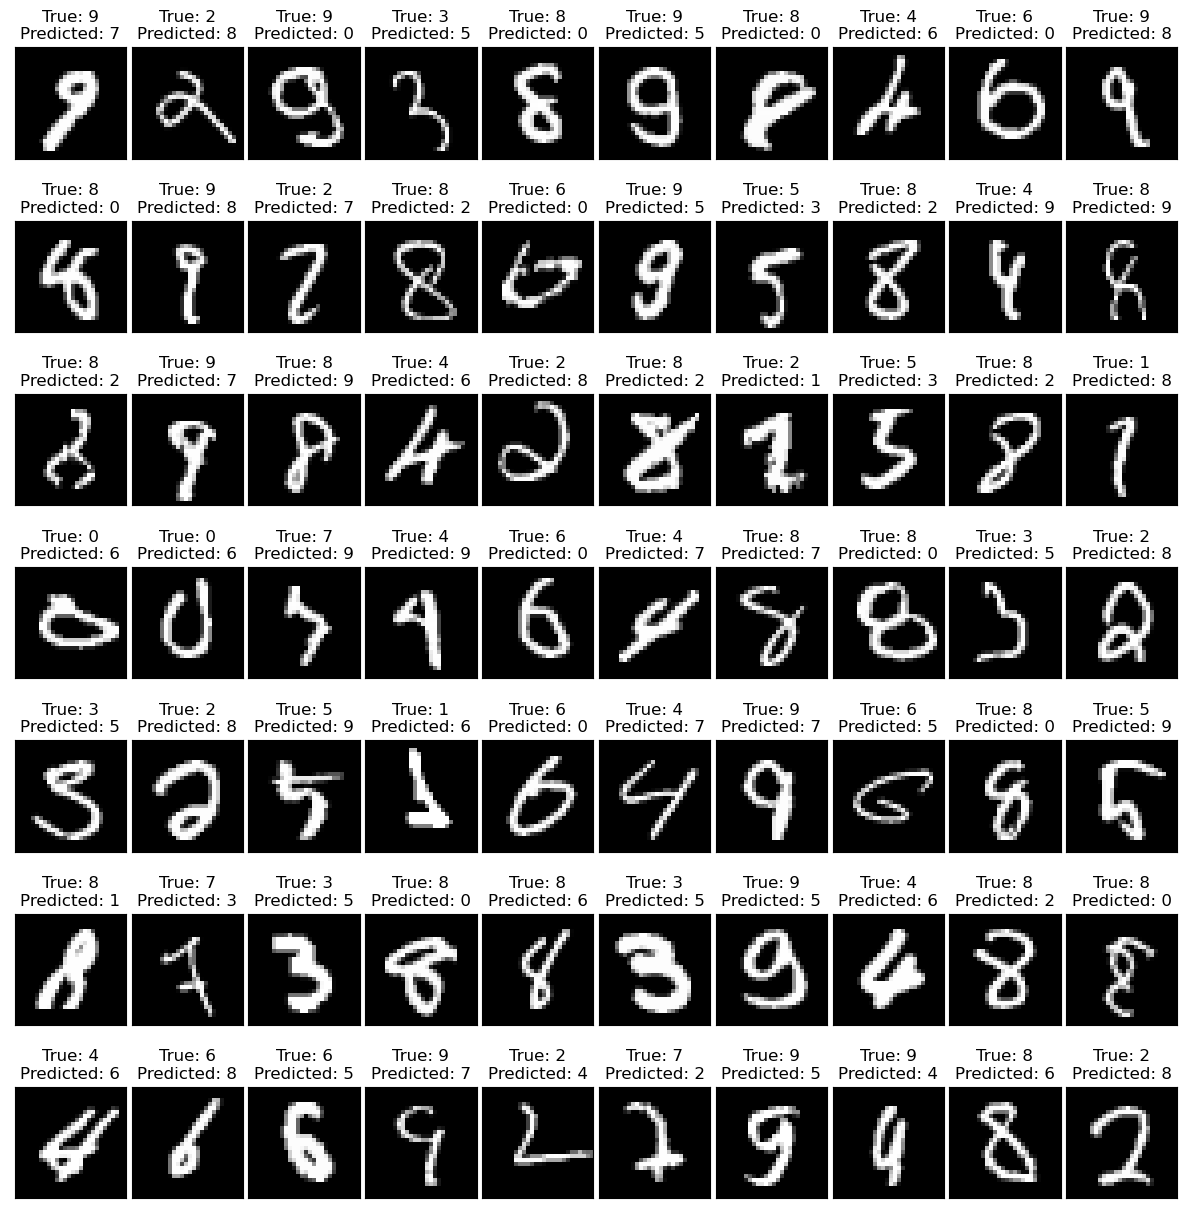

In [17]:
import matplotlib.pyplot as plt

# Get the predicted classes for each sample in X_test
predicted_classes = np.argmax(predictions, axis=1)

# Set a threshold for the prediction uncertainty
uncertainty_threshold = 0.9

# Get the indices of the samples with prediction uncertainty above the threshold
uncertain_indices = np.where(np.max(predictions, axis=1) < uncertainty_threshold)[0]

num_images = 70

wrong_indices = [i for i, prediction in enumerate(predicted_classes) if prediction != y_test[i]]
rows = num_images // 10 + (num_images % 10 != 0)
fig, axs = plt.subplots(rows, 10, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.5, wspace=0.05)
axs = axs.ravel()
for i, index in enumerate(wrong_indices[:num_images]):
    axs[i].imshow(X_test[index].reshape(28, 28), cmap="gray")
    axs[i].set_title("True: {}\nPredicted: {}".format(y_test[index], predicted_classes[index]))
for i in range(num_images, rows * 10):
    fig.delaxes(axs[i])
plt.show()

With some of them you can understand why the images were wrongly classified, but others look quite clear. Now we have to do some fine tuning, I will do that in the next blog entry.
